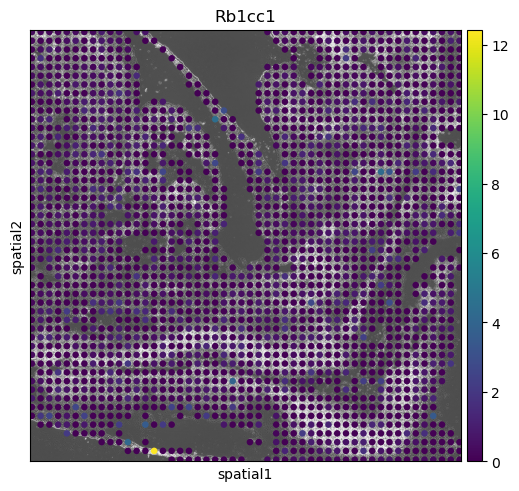

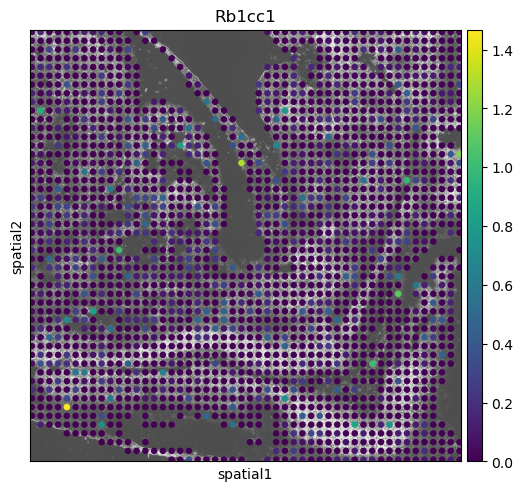

In [30]:
import numpy as np
import pandas as pd
import scanpy as sc
data_ac = sc.read_h5ad('../Dataset/7_ME13_1/adata_H3K27ac_ATAC.h5ad')
data_me3 = sc.read_h5ad('../Dataset/7_ME13_1/adata_H3K27me3_ATAC.h5ad')

position = pd.read_csv('../Dataset/7_ME13_1/spatial/tissue_positions_list.csv', header=None, index_col=0)
data_ac.obsm['spatial'] = position.loc[data_ac.obs_names, :].iloc[:, [4, 3]].values
data_me3.obsm['spatial'] = position.loc[data_ac.obs_names, :].iloc[:, [4, 3]].values
from PIL import Image
import json
# Load the image
image = Image.open('../Dataset/7_ME13_1/spatial/tissue_lowres_image.png')
with open('../Dataset/7_ME13_1/spatial/scalefactors_json.json', 'r') as f:
    scalefactors = json.load(f)
data_ac.uns['spatial'] = {}
data_ac.uns['spatial']['ME13_1'] = {'images': {'lowres': np.array(image)}, 'scalefactors': scalefactors}
data_me3.uns['spatial'] = {}
data_me3.uns['spatial']['ME13_1'] = {'images': {'lowres': np.array(image)}, 'scalefactors': scalefactors}

import squidpy as sq

sq.pl.spatial_scatter(data_ac, color=data_ac.var_names[10], library_key='ME13_1', img_res_key='lowres', size=3)
sq.pl.spatial_scatter(data_me3, color=data_me3.var_names[10], library_key='ME13_1', img_res_key='lowres', size=3)

data_ac.write_h5ad('../Dataset/7_ME13_1/adata_H3K27ac_ATAC.h5ad')
data_me3.write_h5ad('../Dataset/7_ME13_1/adata_H3K27me3_ATAC.h5ad')

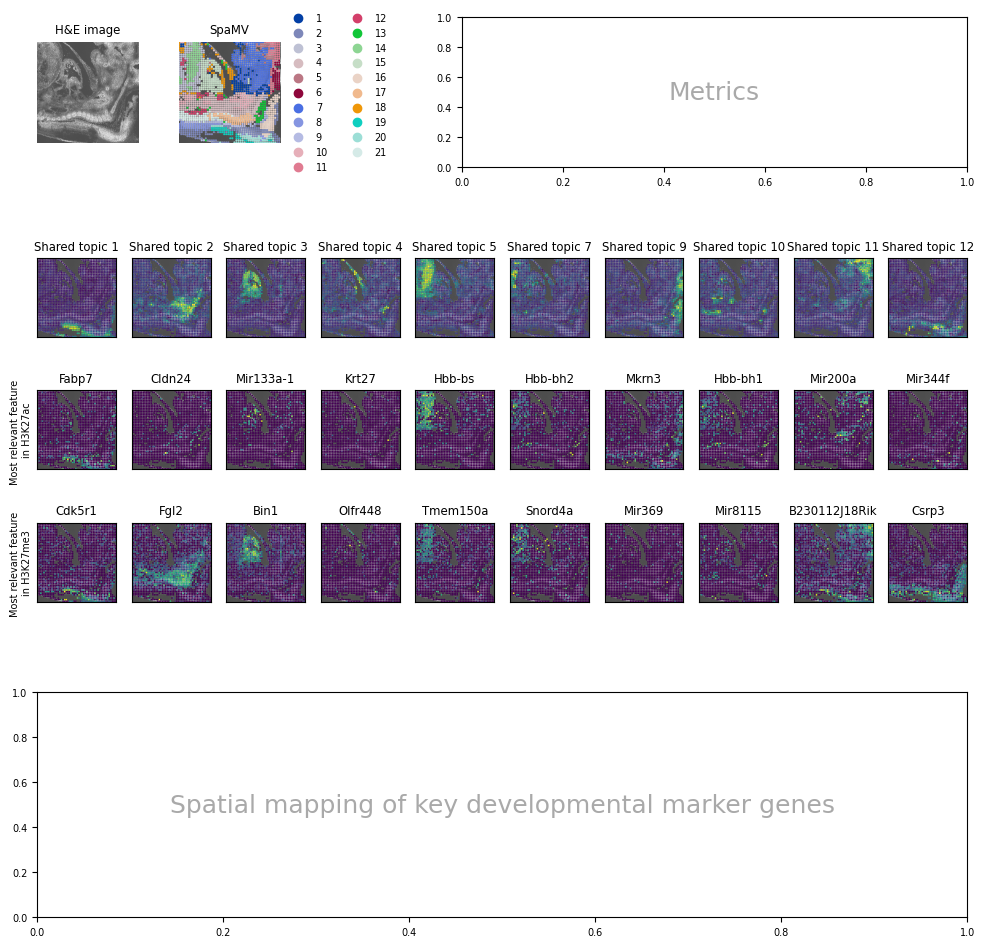

In [16]:
import matplotlib
import warnings

warnings.filterwarnings("ignore")
import scanpy as sc
from scanpy.plotting import embedding
from sklearn.metrics import adjusted_rand_score
import scvi
import squidpy as sq
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec

font = {'size': 7}

matplotlib.rc('font', **font)


def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")

n_topics = 10
cluster_size = 20
cluster_size_4 = 10
dr_size = 50
width = 12
height = 15
# load mouse embryo dataset
fig = plt.figure(figsize=(width, height))
spec_clustering = GridSpec(1, 4, width_ratios=[1, 1, 1, 5])
spec_clustering.update(top=.95, bottom=.85)
he = plt.subplot(spec_clustering[0, 0])
spamv = plt.subplot(spec_clustering[0, 1])
unknown1 = plt.subplot(spec_clustering[0, 3])
annotate_axes(unknown1, 'Metrics')

data_ac = sc.read_h5ad('../Dataset/7_ME13_1/adata_H3K27ac_ATAC.h5ad')
data_me3 = sc.read_h5ad('../Dataset/7_ME13_1/adata_H3K27me3_ATAC.h5ad')
sc.pp.normalize_total(data_ac)
sc.pp.log1p(data_ac)
sc.pp.normalize_total(data_me3)
sc.pp.log1p(data_me3)
data_spamv = sc.read_h5ad('../Results/7_ME13_1/adata_SpaMV.h5ad')
data_spamv.uns.pop('SpaMV_colors')

sq.pl.spatial_scatter(data_ac, color=data_ac.var_names[0], ax=he, title='H&E image', size=0, img_res_key='lowres', colorbar=False, frameon=False)
sq.pl.spatial_scatter(data_spamv, color='SpaMV', ax=spamv, size=4, img_res_key='lowres', frameon=False)

spec_dimension_reduction = GridSpec(3, 10)
spec_dimension_reduction.update(top=.8, bottom=.55)
# plot dimension reduction results
spot_topic = pd.read_csv('../Results/7_ME13_1/SpaMV_z.csv')
feature_topic = [pd.read_csv('../Results/7_ME13_1/SpaMV_w_H3K27ac.csv', index_col=0), pd.read_csv('../Results/7_ME13_1/SpaMV_w_H3K27me3.csv', index_col=0)]

data_ac.obs = spot_topic
f_dict = {}
i = 0
for topic in spot_topic.columns[:10]:
    if i == 0:
        f_preserved = [topic + '_1', topic + '_2']
    f_dict[topic] = plt.subplot(spec_dimension_reduction[0, i])
    sq.pl.spatial_scatter(data_ac, color=topic, ax=f_dict[topic], img_res_key='lowres', frameon=True, size=4, colorbar=False)
    f_dict[topic + '_1'] = plt.subplot(spec_dimension_reduction[1, i])
    sq.pl.spatial_scatter(data_ac, color=str(feature_topic[0].nlargest(1, topic).index[0]), ax=f_dict[topic + '_1'], img_res_key='lowres', frameon=True, size=4, colorbar=False)
    f_dict[topic + '_2'] = plt.subplot(spec_dimension_reduction[2, i])
    sq.pl.spatial_scatter(data_me3, color=str(feature_topic[1].nlargest(1, topic).index[0]), ax=f_dict[topic + '_2'], img_res_key='lowres', frameon=True, size=4, colorbar=False)
    i += 1
for key, f in f_dict.items():
    f.axes.get_xaxis().set_visible(False)
    if key in f_preserved and '_1' in key:
        f.set_ylabel('Most relevant feature \nin H3K27ac')
    elif key in f_preserved and '_2' in key:
        f.set_ylabel("Most relevant feature \nin H3K27me3")
    else:
        f.axes.get_yaxis().set_visible(False)
        
spec_diff = GridSpec(1, 1)
spec_diff.update(top=.5, bottom=.35)
unknown2 = plt.subplot(spec_diff[0, 0])
annotate_axes(unknown2, 'Spatial mapping of key developmental marker genes')
plt.tight_layout()
plt.savefig('../Figures/visualisation_4.pdf')
plt.show()